# Statistics Practice Questions — Assignment  
**Submitter Name:** Aasif Majeed  
**Date:** 11 April 2024  

This notebook solves the full set of practice questions from the **Statistical Assignment PDF**.

For each question, you will see:
- **Question number + question statement**
- **Explanation (concept + formula)**
- **Python implementation**
- Output / visualization (where required)


---
## 0) Imports & Utility Functions
We use:
- `numpy` for numeric work and random generation
- `pandas` for tabular display
- `matplotlib` for plots
- `scipy.stats` for distributions, KDE, hypothesis tests, ANOVA, chi-square tests
- `seaborn` only to load the *tips* dataset (plots will still be made with matplotlib)
---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import factorial
from scipy import stats

# For reproducibility where needed
np.random.seed(42)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)
np.set_printoptions(suppress=True)


In [2]:
from collections import Counter

def one_sample_ztest(sample, mu0, alternative="two-sided"):
    """One-sample z-test using sample std as sigma estimate (common for practice questions).
    alternative: 'two-sided', 'larger', 'smaller'
    Returns: z_stat, p_value
    """
    x = np.asarray(sample, dtype=float)
    n = len(x)
    xbar = x.mean()
    s = x.std(ddof=1)
    se = s / np.sqrt(n)
    z = (xbar - mu0) / se
    if alternative == "two-sided":
        p = 2 * stats.norm.sf(abs(z))
    elif alternative == "larger":
        p = stats.norm.sf(z)   # P(Z > z)
    elif alternative == "smaller":
        p = stats.norm.cdf(z)  # P(Z < z)
    else:
        raise ValueError("alternative must be 'two-sided', 'larger', or 'smaller'")
    return z, p

def two_proportion_ztest(x1, n1, x2, n2, alternative="two-sided"):
    """Two-proportion z-test with pooled proportion. Returns z, p, p1, p2."""
    p1 = x1 / n1
    p2 = x2 / n2
    p_pool = (x1 + x2) / (n1 + n2)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    z = (p2 - p1) / se  # (new - old)
    if alternative == "two-sided":
        p = 2 * stats.norm.sf(abs(z))
    elif alternative == "larger":
        p = stats.norm.sf(z)
    elif alternative == "smaller":
        p = stats.norm.cdf(z)
    else:
        raise ValueError("alternative must be 'two-sided', 'larger', or 'smaller'")
    return z, p, p1, p2

def welch_ttest(a, b, alternative="two-sided"):
    """Welch's t-test: returns t-stat, df, p-value."""
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    n1, n2 = len(a), len(b)
    m1, m2 = a.mean(), b.mean()
    s1, s2 = a.var(ddof=1), b.var(ddof=1)
    se = np.sqrt(s1/n1 + s2/n2)
    t = (m1 - m2) / se
    df = (s1/n1 + s2/n2)**2 / ((s1/n1)**2/(n1-1) + (s2/n2)**2/(n2-1))
    if alternative == "two-sided":
        p = 2 * stats.t.sf(abs(t), df)
    elif alternative == "larger":
        p = stats.t.sf(t, df)
    elif alternative == "smaller":
        p = stats.t.cdf(t, df)
    else:
        raise ValueError("alternative must be 'two-sided', 'larger', or 'smaller'")
    return t, df, p


---
# 1) Generate `int_list` (100 integers between 90 and 130) and compute statistics
---


## Q1) Generate a list of 100 integers containing values between 90 to 130 and store it in `int_list`.

In [3]:
int_list = np.random.randint(90, 131, size=100).tolist()
int_list[:10], len(int_list), (min(int_list), max(int_list))


([128, 118, 104, 97, 110, 128, 108, 112, 100, 100], 100, (90, 130))

## Q1(i) Mean and Median

### Explanation
- **Mean**: \(\bar{x} = \frac{1}{n}\sum x_i\)
- **Median**: middle value after sorting (or average of two middle values if n is even)


In [4]:
def mean_list(values):
    values = list(values)
    return sum(values) / len(values)

def median_list(values):
    values = sorted(values)
    n = len(values)
    mid = n // 2
    if n % 2 == 1:
        return values[mid]
    return (values[mid-1] + values[mid]) / 2

print("Mean  :", mean_list(int_list))
print("Median:", median_list(int_list))


Mean  : 108.94
Median: 109.5


## Q1(ii) Mode

### Explanation
Mode is the value(s) with the highest frequency.


In [5]:
def mode_list(values):
    counts = Counter(values)
    max_freq = max(counts.values())
    modes = [k for k,v in counts.items() if v == max_freq]
    return modes, max_freq

modes, freq = mode_list(int_list)
print("Mode(s):", modes)
print("Frequency:", freq)


Mode(s): [97, 113]
Frequency: 6


## Q1(iii) Weighted Mean

### Explanation
\[ \bar{x}_w = \frac{\sum w_i x_i}{\sum w_i} \]


In [6]:
def weighted_mean(values, weights):
    values = np.asarray(values, dtype=float)
    weights = np.asarray(weights, dtype=float)
    if len(values) != len(weights):
        raise ValueError("values and weights must be same length")
    if np.sum(weights) == 0:
        raise ValueError("sum of weights cannot be 0")
    return float(np.sum(values * weights) / np.sum(weights))

vals = int_list[:10]
wts = np.random.randint(1, 6, size=10)
print("Values :", vals)
print("Weights:", wts.tolist())
print("Weighted mean:", weighted_mean(vals, wts))


Values : [128, 118, 104, 97, 110, 128, 108, 112, 100, 100]
Weights: [2, 1, 5, 3, 4, 3, 3, 1, 3, 5]
Weighted mean: 108.16666666666667


## Q1(iv) Geometric Mean

### Explanation
For positive numbers:
\[ GM = \exp\left(\frac{1}{n}\sum \ln(x_i)\right) \]


In [7]:
def geometric_mean(values):
    x = np.asarray(values, dtype=float)
    if np.any(x <= 0):
        raise ValueError("Geometric mean requires all values > 0")
    return float(np.exp(np.mean(np.log(x))))

print("Geometric mean:", geometric_mean(int_list))


Geometric mean: 108.31139336758402


## Q1(v) Harmonic Mean

### Explanation
For positive numbers:
\[ HM = \frac{n}{\sum 1/x_i} \]


In [8]:
def harmonic_mean(values):
    x = np.asarray(values, dtype=float)
    if np.any(x <= 0):
        raise ValueError("Harmonic mean requires all values > 0")
    return float(len(x) / np.sum(1.0/x))

print("Harmonic mean:", harmonic_mean(int_list))


Harmonic mean: 107.6871736661807


## Q1(vi) Midrange

### Explanation
\[ midrange = \frac{\min(x) + \max(x)}{2} \]


In [9]:
def midrange(values):
    return (min(values) + max(values)) / 2

print("Midrange:", midrange(int_list))


Midrange: 110.0


## Q1(vii) Trimmed Mean

### Explanation
A trimmed mean removes a fixed fraction of smallest and largest values before averaging.


In [10]:
def trimmed_mean(values, trim_percent=0.1):
    x = sorted(values)
    n = len(x)
    k = int(np.floor(trim_percent * n))
    trimmed = x[k:n-k] if n - 2*k > 0 else []
    if not trimmed:
        raise ValueError("Trim percent too large; removed all data.")
    return sum(trimmed) / len(trimmed)

print("Trimmed mean (10%):", trimmed_mean(int_list, 0.10))
print("Trimmed mean (20%):", trimmed_mean(int_list, 0.20))


Trimmed mean (10%): 108.675
Trimmed mean (20%): 108.28333333333333


---
# 2) Generate `int_list2` (500 integers between 200 and 300) and compute dispersion + plots
---


## Q2) Generate `int_list2` (500 integers in [200, 300]).

In [11]:
int_list2 = np.random.randint(200, 301, size=500).tolist()
len(int_list2), (min(int_list2), max(int_list2)), int_list2[:10]


(500, (200, 300), [246, 277, 202, 200, 204, 289, 213, 226, 208, 278])

## Q2(i) Compare visualizations:
1. Histogram (frequency) & Gaussian distribution  
2. Smoothened KDE plot  
3. Gaussian distribution & KDE together  

We use `scipy.stats.gaussian_kde` for KDE and overlay a fitted normal PDF.


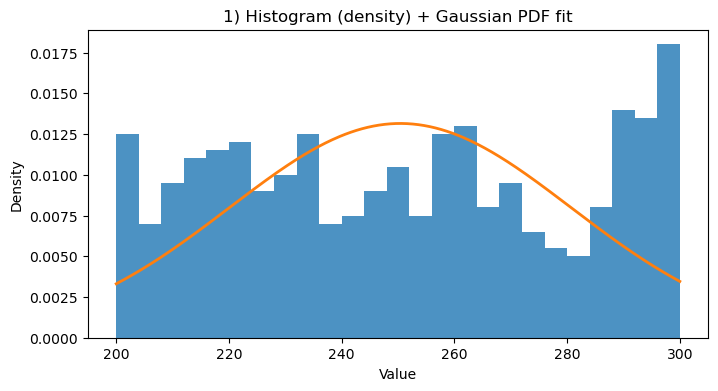

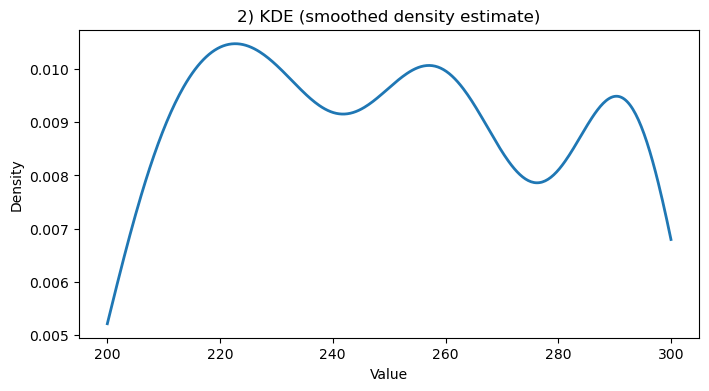

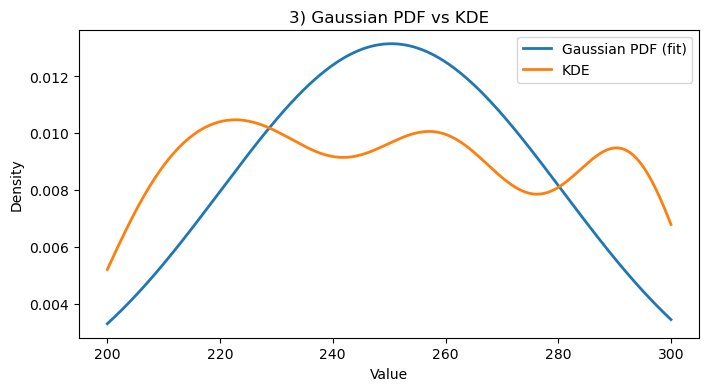

Estimated mean: 250.398
Estimated std : 30.34246077449394


In [12]:
data2 = np.array(int_list2, dtype=float)
mu, sigma = data2.mean(), data2.std(ddof=1)

x_grid = np.linspace(data2.min(), data2.max(), 400)
normal_pdf = stats.norm.pdf(x_grid, loc=mu, scale=sigma)

kde = stats.gaussian_kde(data2)
kde_pdf = kde(x_grid)

plt.figure(figsize=(8,4))
plt.hist(data2, bins=25, density=True, alpha=0.8)
plt.plot(x_grid, normal_pdf, linewidth=2)
plt.title("1) Histogram (density) + Gaussian PDF fit")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(x_grid, kde_pdf, linewidth=2)
plt.title("2) KDE (smoothed density estimate)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(x_grid, normal_pdf, linewidth=2, label="Gaussian PDF (fit)")
plt.plot(x_grid, kde_pdf, linewidth=2, label="KDE")
plt.title("3) Gaussian PDF vs KDE")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

print("Estimated mean:", mu)
print("Estimated std :", sigma)


## Q2(ii) Range

Range = max − min.


In [13]:
def data_range(values):
    return max(values) - min(values)

print("Range:", data_range(int_list2))


Range: 100


## Q2(iii) Variance and Standard Deviation (sample)

Sample variance uses ddof=1.


In [14]:
def variance_std(values):
    x = np.asarray(values, dtype=float)
    return float(x.var(ddof=1)), float(x.std(ddof=1))

var2, std2 = variance_std(int_list2)
print("Variance:", var2)
print("Std Dev :", std2)


Variance: 920.6649258517034
Std Dev : 30.34246077449394


## Q2(iv) Interquartile Range (IQR)

IQR = Q3 − Q1 (75th percentile − 25th percentile).


In [15]:
def iqr(values):
    x = np.asarray(values, dtype=float)
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    return float(q1), float(q3), float(q3 - q1)

q1, q3, iqr_val = iqr(int_list2)
print("Q1:", q1, "Q3:", q3, "IQR:", iqr_val)


Q1: 223.0 Q3: 277.0 IQR: 54.0


## Q2(v) Coefficient of Variation (CV)

CV = (std / mean) × 100%


In [16]:
def coefficient_of_variation(values):
    x = np.asarray(values, dtype=float)
    return float((x.std(ddof=1) / x.mean()) * 100)

print("CV (%):", coefficient_of_variation(int_list2))


CV (%): 12.117692942632905


## Q2(vi) Mean Absolute Deviation (MAD)

MAD = mean(|x − mean(x)|)


In [17]:
def mad(values):
    x = np.asarray(values, dtype=float)
    return float(np.mean(np.abs(x - x.mean())))

print("MAD:", mad(int_list2))


MAD: 26.25


## Q2(vii) Quartile Deviation

Quartile deviation (semi-IQR) = (Q3 − Q1)/2


In [18]:
def quartile_deviation(values):
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    return float((q3 - q1) / 2)

print("Quartile Deviation:", quartile_deviation(int_list2))


Quartile Deviation: 27.0


## Q2(viii) Range-based coefficient of dispersion

One common formula:
\[ CoD = \frac{max - min}{max + min} \]


In [19]:
def range_based_cod(values):
    mn, mx = min(values), max(values)
    return float((mx - mn) / (mx + mn))

print("Range-based CoD:", range_based_cod(int_list2))


Range-based CoD: 0.2


---
# 3) Discrete Random Variable Class
---


## Q3) Python class for a discrete random variable (Expected Value & Variance)

For values x_i with probabilities p_i:
- E[X] = Σ x_i p_i
- Var(X) = E[X²] − (E[X])²


In [20]:
class DiscreteRandomVariable:
    def __init__(self, values, probs):
        self.values = np.asarray(values, dtype=float)
        self.probs = np.asarray(probs, dtype=float)
        if len(self.values) != len(self.probs):
            raise ValueError("values and probs must have the same length")
        if np.any(self.probs < 0):
            raise ValueError("probabilities must be non-negative")
        s = self.probs.sum()
        if not np.isclose(s, 1.0):
            self.probs = self.probs / s  # normalize

    def expected_value(self):
        return float(np.sum(self.values * self.probs))

    def variance(self):
        ex = self.expected_value()
        ex2 = float(np.sum((self.values**2) * self.probs))
        return ex2 - ex**2

# Demo: fair die
drv = DiscreteRandomVariable([1,2,3,4,5,6], [1/6]*6)
print("E[X]:", drv.expected_value())
print("Var(X):", drv.variance())


E[X]: 3.5
Var(X): 2.916666666666666


## Q4) Simulate rolling a fair 6-sided die and compute expected value and variance.


In [21]:
def simulate_die(n_rolls=20000):
    rolls = np.random.randint(1, 7, size=n_rolls)
    return float(rolls.mean()), float(rolls.var(ddof=1))

mean_roll, var_roll = simulate_die()
print("Simulated mean:", mean_roll)
print("Simulated variance:", var_roll)
print("Theoretical mean:", 3.5)
print("Theoretical variance:", 35/12)


Simulated mean: 3.49935
Simulated variance: 2.92584586979349
Theoretical mean: 3.5
Theoretical variance: 2.9166666666666665


## Q5) Random samples from Binomial/Poisson distributions and compute mean/variance.


In [22]:
def sample_distribution(dist_name, size=20000, **params):
    if dist_name.lower() == "binomial":
        n = params.get("n", 10)
        p = params.get("p", 0.5)
        samples = np.random.binomial(n=n, p=p, size=size)
    elif dist_name.lower() == "poisson":
        lam = params.get("lam", 3.0)
        samples = np.random.poisson(lam=lam, size=size)
    else:
        raise ValueError("Supported: binomial, poisson")
    return samples, float(samples.mean()), float(samples.var(ddof=1))

_, bm, bv = sample_distribution("binomial", n=20, p=0.3)
_, pm, pv = sample_distribution("poisson", lam=4.5)
print("Binomial(20,0.3): mean=", bm, "var=", bv)
print("Poisson(4.5): mean=", pm, "var=", pv)


Binomial(20,0.3): mean= 6.01795 var= 4.209238259412971
Poisson(4.5): mean= 4.5092 var= 4.4577382469123465


## Q6) Gaussian samples: compute mean, variance, std.


In [23]:
mu_true, sigma_true = 50, 10
samples = np.random.normal(mu_true, sigma_true, size=10000)
print("Sample mean:", float(samples.mean()))
print("Sample variance:", float(samples.var(ddof=1)))
print("Sample std:", float(samples.std(ddof=1)))


Sample mean: 49.946099810155694
Sample variance: 101.30789130916662
Sample std: 10.065182129955057


## Q7) Tips dataset (Seaborn) — skewness, covariance, correlation, scatter plot

Columns: `total_bill` and `tip`


In [24]:
import seaborn as sns
tips = sns.load_dataset("tips")
tips.head()


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Skewness(total_bill): 1.1332130376158205 => Positive skewness (right-skewed)
Skewness(tip)       : 1.46545103709794 => Positive skewness (right-skewed)
Covariance(total_bill, tip): 8.323501629224854
Pearson correlation: 0.6757341092113645


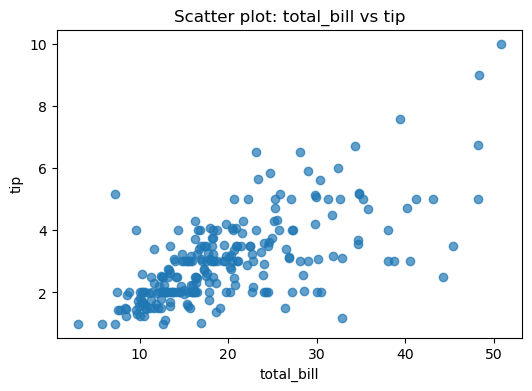

In [25]:
total_bill = tips["total_bill"].to_numpy()
tip = tips["tip"].to_numpy()

def skewness(x):
    return float(stats.skew(x, bias=False))

def skew_type(sk, tol=0.05):
    if sk > tol:
        return "Positive skewness (right-skewed)"
    if sk < -tol:
        return "Negative skewness (left-skewed)"
    return "Approximately symmetric"

sk_tb = skewness(total_bill)
sk_tip = skewness(tip)
print("Skewness(total_bill):", sk_tb, "=>", skew_type(sk_tb))
print("Skewness(tip)       :", sk_tip, "=>", skew_type(sk_tip))

cov_tb_tip = float(np.cov(total_bill, tip, ddof=1)[0,1])
corr_tb_tip = float(np.corrcoef(total_bill, tip)[0,1])

print("Covariance(total_bill, tip):", cov_tb_tip)
print("Pearson correlation:", corr_tb_tip)

plt.figure(figsize=(6,4))
plt.scatter(total_bill, tip, alpha=0.7)
plt.title("Scatter plot: total_bill vs tip")
plt.xlabel("total_bill")
plt.ylabel("tip")
plt.show()


## Q8) Normal distribution PDF function


In [26]:
def normal_pdf(x, mu=0.0, sigma=1.0):
    x = np.asarray(x, dtype=float)
    return (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-((x-mu)**2)/(2*sigma**2))

x = np.linspace(-3, 3, 7)
print("x:", x)
print("pdf:", normal_pdf(x, mu=0, sigma=1))


x: [-3. -2. -1.  0.  1.  2.  3.]
pdf: [0.00443185 0.05399097 0.24197072 0.39894228 0.24197072 0.05399097
 0.00443185]


## Q9) Exponential distribution CDF function


In [27]:
def exponential_cdf(x, lam=1.0):
    x = np.asarray(x, dtype=float)
    cdf = np.zeros_like(x)
    mask = x >= 0
    cdf[mask] = 1 - np.exp(-lam * x[mask])
    return cdf

x = np.array([-1, 0, 0.5, 1, 2])
print("x:", x)
print("CDF:", exponential_cdf(x, lam=2.0))


x: [-1.   0.   0.5  1.   2. ]
CDF: [0.         0.         0.63212056 0.86466472 0.98168436]


## Q10) Poisson distribution PMF function


In [28]:
def poisson_pmf(k, lam=1.0):
    k = np.asarray(k, dtype=int)
    return np.exp(-lam) * (lam**k) / np.vectorize(factorial)(k)

k = np.arange(0, 6)
print("k:", k)
print("PMF:", poisson_pmf(k, lam=3.0))


k: [0 1 2 3 4 5]
PMF: [0.04978707 0.14936121 0.22404181 0.22404181 0.16803136 0.10081881]


---
# Hypothesis Testing (Z-test, t-test, Chi-square, ANOVA)
---


## Q11) Two-proportion Z-test: Old vs New website layout conversion

H0: p_new ≤ p_old  
H1: p_new > p_old


In [29]:
old_layout = np.array([1] * 50 + [0] * 950)
new_layout = np.array([1] * 70 + [0] * 930)

x1, n1 = old_layout.sum(), len(old_layout)
x2, n2 = new_layout.sum(), len(new_layout)

z, p, p_old, p_new = two_proportion_ztest(x1, n1, x2, n2, alternative="larger")

print("Old conversion rate:", p_old)
print("New conversion rate:", p_new)
print("Z-stat:", z)
print("p-value:", p)

alpha = 0.05
print("Decision:", "Reject H0 (new better)" if p < alpha else "Fail to reject H0")


Old conversion rate: 0.05
New conversion rate: 0.07
Z-stat: 1.883108942886774
p-value: 0.029842802766213112
Decision: Reject H0 (new better)


## Q12) Paired Z-test: Tutoring program improves exam scores

Let d = after − before.  
H0: mean(d) ≤ 0  
H1: mean(d) > 0


In [30]:
before_program = np.array([75, 80, 85, 70, 90, 78, 92, 88, 82, 87])
after_program  = np.array([80, 85, 90, 80, 92, 80, 95, 90, 85, 88])

diff = after_program - before_program
z, p = one_sample_ztest(diff, mu0=0, alternative="larger")

print("Differences (after-before):", diff)
print("Mean difference:", float(diff.mean()))
print("Z-stat:", z)
print("p-value:", p)

alpha = 0.05
print("Decision:", "Reject H0 (improvement supported)" if p < alpha else "Fail to reject H0")


Differences (after-before): [ 5  5  5 10  2  2  3  2  3  1]
Mean difference: 3.8
Z-stat: 4.593190894944668
p-value: 2.182597052671683e-06
Decision: Reject H0 (improvement supported)


## Q13) Paired Z-test: Drug reduces blood pressure

Let r = before − after.  
H0: mean(r) ≤ 0  
H1: mean(r) > 0


In [31]:
before_drug = np.array([145, 150, 140, 135, 155, 160, 152, 148, 130, 138])
after_drug  = np.array([130, 140, 132, 128, 145, 148, 138, 136, 125, 130])

reduction = before_drug - after_drug
z, p = one_sample_ztest(reduction, mu0=0, alternative="larger")

print("Reductions (before-after):", reduction)
print("Mean reduction:", float(reduction.mean()))
print("Z-stat:", z)
print("p-value:", p)

alpha = 0.05
print("Decision:", "Reject H0 (drug works)" if p < alpha else "Fail to reject H0")


Reductions (before-after): [15 10  8  7 10 12 14 12  5  8]
Mean reduction: 10.1
Z-stat: 10.049875621120888
p-value: 4.5991722038501935e-24
Decision: Reject H0 (drug works)


## Q14) One-sample Z-test: Response time < 5 minutes

H0: μ ≥ 5  
H1: μ < 5


In [32]:
response_times = np.array([4.3, 3.8, 5.1, 4.9, 4.7, 4.2, 5.2, 4.5, 4.6, 4.4])

z, p = one_sample_ztest(response_times, mu0=5.0, alternative="smaller")

print("Sample mean:", float(response_times.mean()))
print("Z-stat:", z)
print("p-value:", p)

alpha = 0.05
print("Decision:", "Reject H0 (mean < 5 supported)" if p < alpha else "Fail to reject H0")


Sample mean: 4.57
Z-stat: -3.184457226042963
p-value: 0.0007251287113068958
Decision: Reject H0 (mean < 5 supported)


## Q15) A/B test analysis (Welch t-test): t-statistic, df, p-value

H0: meanA = meanB  
H1: meanA ≠ meanB


In [33]:
layout_a_clicks = [28, 32, 33, 29, 31, 34, 30, 35, 36, 37]
layout_b_clicks = [40, 41, 38, 42, 39, 44, 43, 41, 45, 47]

t, df, p = welch_ttest(layout_a_clicks, layout_b_clicks, alternative="two-sided")
print("Mean A:", float(np.mean(layout_a_clicks)))
print("Mean B:", float(np.mean(layout_b_clicks)))
print("t-stat:", t)
print("df:", df)
print("p-value:", p)


Mean A: 32.5
Mean B: 42.0
t-stat: -7.298102156175071
df: 17.879871863320876
p-value: 9.196596070789357e-07


## Q16) New drug vs existing drug (Welch t-test): is new drug better (lower cholesterol)?

H0: mean_new ≥ mean_existing  
H1: mean_new < mean_existing


In [34]:
existing_drug_levels = [180, 182, 175, 185, 178, 176, 172, 184, 179, 183]
new_drug_levels      = [170, 172, 165, 168, 175, 173, 170, 178, 172, 176]

t, df, p = welch_ttest(new_drug_levels, existing_drug_levels, alternative="smaller")
print("Mean existing:", float(np.mean(existing_drug_levels)))
print("Mean new     :", float(np.mean(new_drug_levels)))
print("t-stat (new-existing):", t)
print("df:", df)
print("p-value:", p)

alpha = 0.05
print("Decision:", "Reject H0 (new drug reduces more)" if p < alpha else "Fail to reject H0")


Mean existing: 179.4
Mean new     : 171.9
t-stat (new-existing): -4.14048098620866
df: 17.866770765582338
p-value: 0.00031146144727346535
Decision: Reject H0 (new drug reduces more)


## Q17) Pre vs post intervention (paired t-test)

H0: mean(post - pre) ≤ 0  
H1: mean(post - pre) > 0


In [35]:
pre_intervention_scores  = np.array([80, 85, 90, 75, 88, 82, 92, 78, 85, 87])
post_intervention_scores = np.array([90, 92, 88, 92, 95, 91, 96, 93, 89, 93])

t_stat, p_two = stats.ttest_rel(post_intervention_scores, pre_intervention_scores)
p_one = (p_two/2) if t_stat > 0 else (1 - p_two/2)

print("Mean pre :", float(pre_intervention_scores.mean()))
print("Mean post:", float(post_intervention_scores.mean()))
print("t-stat:", t_stat)
print("df:", len(pre_intervention_scores)-1)
print("two-sided p:", p_two)
print("one-sided p (post>pre):", p_one)

alpha = 0.05
print("Decision:", "Reject H0 (improves)" if p_one < alpha else "Fail to reject H0")


Mean pre : 84.2
Mean post: 91.9
t-stat: 4.42840883965761
df: 9
two-sided p: 0.0016509548165795493
one-sided p (post>pre): 0.0008254774082897746
Decision: Reject H0 (improves)


## Q18) Salary gap (Welch t-test, two-sided)

H0: mean_male = mean_female  
H1: mean_male ≠ mean_female


In [36]:
np.random.seed(0)
male_salaries = np.random.normal(loc=50000, scale=10000, size=20)
female_salaries = np.random.normal(loc=55000, scale=9000, size=20)

t, df, p = welch_ttest(male_salaries, female_salaries, alternative="two-sided")
print("Mean male  :", float(male_salaries.mean()))
print("Mean female:", float(female_salaries.mean()))
print("t-stat:", t)
print("df:", df)
print("p-value:", p)


Mean male  : 55693.345929456336
Mean female: 55501.753181380416
t-stat: 0.06114208969630455
df: 36.166783312917644
p-value: 0.9515826849268001


## Q19) Product quality: Version 1 vs Version 2 (Welch t-test, two-sided)


In [37]:
version1_scores = [85, 88, 82, 89, 87, 84, 90, 88, 85, 86, 91, 83, 87, 84, 89, 86, 84, 88, 85, 86, 89, 90, 87, 88, 85]
version2_scores = [80, 78, 83, 81, 79, 82, 76, 80, 78, 81, 77, 82, 80, 79, 82, 79, 80, 81, 79, 82, 79, 78, 80, 81, 82]

t, df, p = welch_ttest(version1_scores, version2_scores, alternative="two-sided")
print("Mean v1:", float(np.mean(version1_scores)))
print("Mean v2:", float(np.mean(version2_scores)))
print("t-stat:", t)
print("df:", df)
print("p-value:", p)


Mean v1: 86.64
Mean v2: 79.96
t-stat: 11.325830417646698
df: 44.47061033283037
p-value: 1.078754084378157e-14


## Q20) Restaurant satisfaction: Branch A vs Branch B (Welch t-test, two-sided)


In [38]:
branch_a_scores = [4, 5, 3, 4, 5, 4, 5, 3, 4, 4, 5, 4, 4, 3, 4, 5, 5, 4, 3, 4, 5, 4, 3, 5, 4, 4, 5, 3, 4, 5, 4]
branch_b_scores = [3, 4, 2, 3, 4, 3, 4, 2, 3, 3, 4, 3, 3, 2, 3, 4, 4, 3, 2, 3, 4, 3, 2, 4, 3, 3, 4, 2, 3, 4, 3]

t, df, p = welch_ttest(branch_a_scores, branch_b_scores, alternative="two-sided")
print("Mean A:", float(np.mean(branch_a_scores)))
print("Mean B:", float(np.mean(branch_b_scores)))
print("t-stat:", t)
print("df:", df)
print("p-value:", p)


Mean A: 4.129032258064516
Mean B: 3.129032258064516
t-stat: 5.480077554195743
df: 60.0
p-value: 8.895290509945655e-07


## Q21) Chi-square test: Age group vs voter preference


In [39]:
np.random.seed(0)
age_groups = np.random.choice(['18-30', '31-50', '51+'], size=30)
voter_preferences = np.random.choice(['Candidate A', 'Candidate B'], size=30)

table = pd.crosstab(age_groups, voter_preferences)
table


col_0,Candidate A,Candidate B
row_0,,
18-30,4,8
31-50,6,5
51+,4,3


In [40]:
chi2, p, dof, expected = stats.chi2_contingency(table.values)
print("Chi-square:", chi2)
print("df:", dof)
print("p-value:", p)

expected_df = pd.DataFrame(expected, index=table.index, columns=table.columns)
display(expected_df)


Chi-square: 1.4401669758812612
df: 2
p-value: 0.48671161971286614


col_0,Candidate A,Candidate B
row_0,,
18-30,5.600000,6.400000
31-50,5.133333,5.866667
51+,3.266667,3.733333


## Q22) Chi-square test: Satisfaction levels vs regions


In [41]:
data = np.array([[50, 30, 40, 20], 
                 [30, 40, 30, 50], 
                 [20, 30, 40, 30]])

chi2, p, dof, expected = stats.chi2_contingency(data)
print("Chi-square:", chi2)
print("df:", dof)
print("p-value:", p)


Chi-square: 27.777056277056275
df: 6
p-value: 0.00010349448486004387


## Q23) Chi-square test: Job performance before vs after training


In [42]:
data = np.array([[50, 30, 20], 
                 [30, 40, 30], 
                 [20, 30, 40]])

chi2, p, dof, expected = stats.chi2_contingency(data)
print("Chi-square:", chi2)
print("df:", dof)
print("p-value:", p)


Chi-square: 22.161728395061726
df: 4
p-value: 0.00018609719479882557


## Q24) One-way ANOVA: Standard vs Premium vs Deluxe satisfaction scores


In [43]:
standard_scores = [80, 85, 90, 78, 88, 82, 92, 78, 85, 87]
premium_scores  = [90, 92, 88, 92, 95, 91, 96, 93, 89, 93]
deluxe_scores   = [95, 98, 92, 97, 96, 94, 98, 97, 92, 99]

f_stat, p_val = stats.f_oneway(standard_scores, premium_scores, deluxe_scores)

print("Mean Standard:", float(np.mean(standard_scores)))
print("Mean Premium :", float(np.mean(premium_scores)))
print("Mean Deluxe  :", float(np.mean(deluxe_scores)))
print("F-stat:", f_stat)
print("p-value:", p_val)


Mean Standard: 84.5
Mean Premium : 91.9
Mean Deluxe  : 95.8
F-stat: 27.03556231003039
p-value: 3.5786328857349003e-07
